In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

import tensorflow as tf
from keras.utils import Sequence
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Flatten, Dense
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate, Lambda


In [2]:
cells_paths = [os.path.join('Blood_Cancer', i) for i in next(os.walk('Blood_Cancer'))[2]]

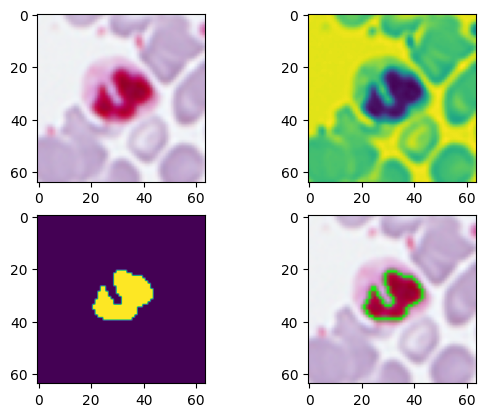

In [3]:
images = []
img = cv2.imread(np.random.choice(cells_paths))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
mask = cv2.inRange(gray, 0, 120)
contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
img_copy = img.copy()
cv2.drawContours(image=img_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
images = [img,gray,mask,img_copy]

fig, axs = plt.subplots(2, 2)
for i, img in enumerate(images):
    axs[i//2,i%2].imshow(img)



In [4]:
data = cells_paths
np.random.shuffle(data)
train, test = data[:int(len(data)*0.7)], data[int(-len(data)*0.3):]

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet():
    inputs = Input((64, 64, 3))
    gray = Lambda(lambda x: tf.image.rgb_to_grayscale(x))(inputs)
    s1, p1 = encoder_block(gray, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
class DataGen(Sequence):
    def __init__(self,train_data, batch_size=16):
        self.batch_size = batch_size
        self.epoch = 0
        self.train_data = train_data
        self.total_points = len(train_data)
        self.steps = int(self.total_points*0.1/batch_size)
        self.x_batch = np.zeros((self.batch_size, 64, 64, 3))
        self.mask = np.zeros((self.batch_size, 64, 64))

    def __len__(self):
        return self.steps


    def __getitem__(self, index):
        self.x_batch = np.zeros((self.batch_size, 64, 64, 3))
        self.mask = np.zeros((self.batch_size, 64, 64))
        
        for i in range(self.batch_size):
            img = cv2.imread(np.random.choice(self.train_data))
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            msk = cv2.inRange(gray, 0, 120)
            self.x_batch[i] = img
            self.mask[i] = msk/255
        return self.x_batch, self.mask

    

In [7]:
unet = build_unet()
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
train_gen = DataGen(train,batch_size=10)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

hist = unet.fit(train_gen,
                 epochs=1000,
                 callbacks=[early_stop],
                 verbose=1)
unet.save("unet")


Epoch 1/1000
70/70 [==============================] - 54s 730ms/step - loss: 0.0721
Epoch 2/1000
70/70 [==============================] - 52s 739ms/step - loss: 0.0200
Epoch 3/1000
70/70 [==============================] - 55s 789ms/step - loss: 0.0124
Epoch 4/1000
70/70 [==============================] - 55s 780ms/step - loss: 0.0093
Epoch 5/1000
70/70 [==============================] - 55s 779ms/step - loss: 0.0095
Epoch 6/1000
70/70 [==============================] - 55s 782ms/step - loss: 0.0064
Epoch 7/1000
70/70 [==============================] - 54s 776ms/step - loss: 0.0057
Epoch 8/1000
70/70 [==============================] - 54s 777ms/step - loss: 0.0065
Epoch 9/1000
70/70 [==============================] - 54s 771ms/step - loss: 0.0091


INFO:tensorflow:Assets written to: unet\assets


INFO:tensorflow:Assets written to: unet\assets


In [93]:
test_set = np.random.choice(test,12)
imgs = np.array([cv2.imread(i) for i in test_set])
pred = unet.predict(imgs)

1/1 [==============================] - 0s 158ms/step


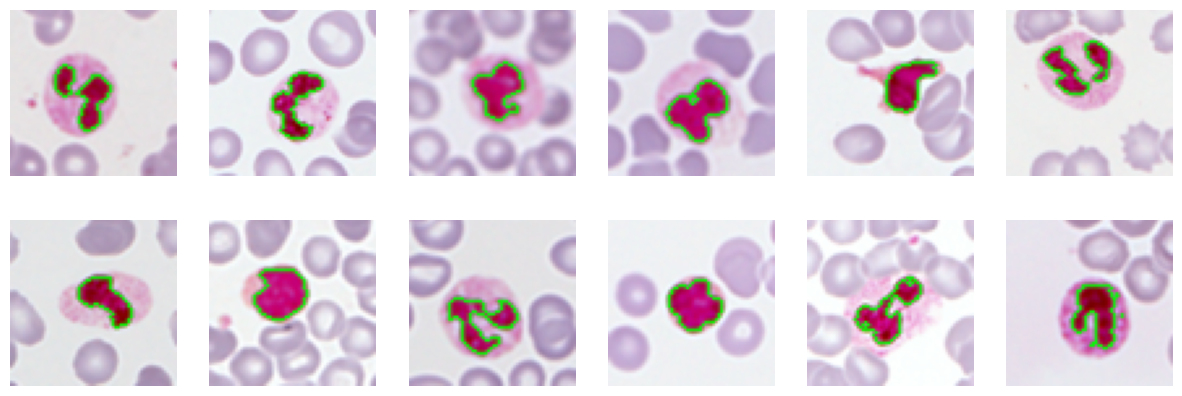

In [94]:
fig, axs = plt.subplots(2,6,figsize=(15,5))
for idx in range(len(test_set)):
    p = np.where(pred[idx] > 0.9,1,0)
    p = cv2.convertScaleAbs(p)
    contours, hierarchy = cv2.findContours(image=p, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    img_copy = imgs[idx].copy()
    cv2.drawContours(image=img_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
    axs[idx%2,idx//2].imshow(img_copy)
    axs[idx%2,idx//2].axis('off')
plt.show()